In [1]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.colors as colors
import math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import plotly.express as px
import pickle

from module.variables import *
from module.functions import *

In [2]:
#EU 2020 population and Ophthalmology Data
with open('eu_two_letter.pickle', 'rb') as handle:
    l2c = pickle.load(handle)
EU_pop = pd.read_csv('EU_Pop.csv')


with open('specialty_state_positions.pickle', 'rb') as handle:
    residency_state = pickle.load(handle)

In [111]:
region_to_name = pd.DataFrame([uk_regions, uk_names]).T
region_to_name.columns = ["ABR", "NAME_1"]

In [110]:
providers = pd.DataFrame(uk_data).T
providers.columns = ["Providers", "NAME_1", "Population", "Compensation1"]
providers["Compensation1"] = providers["Compensation1"].astype("float")

In [109]:
state_to_state = pull_all(10, [2017, 2018], uk_regions, "UK").mean()
state_to_state = pd.DataFrame(state_to_state)
state_to_state.reset_index(inplace=True)
state_to_state.columns = ["ABR", "Interest_18"]
state_to_state = state_to_state.merge(region_to_name, on="ABR")
states = geopandas.read_file('GBR_adm/GBR_adm1.shp')
states = states.merge(state_to_state, on="NAME_1")
states = states.merge(providers, on="NAME_1")
states["Rate_100k_18"] = states["Providers"]/states["Population"] * 100000
states["Rate_100k_18"] = states["Rate_100k_18"].astype('float64')
states["Need_18"] = states["Interest_18"]/states["Rate_100k_18"]

In [13]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
# fig, ax = plt.subplots(ncols=2)
cmap = plt.get_cmap('PuBu')
new_cmap = truncate_colormap(cmap, 0.1, 0.9)
# ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
# ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
# plt.show()

In [ ]:
# Geo Map by State
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title('Need for Ophtho Providers 18', fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column='Need_18',
          cmap=new_cmap,
          linewidth=0.9,
            ax=ax1,
            edgecolor='0',
            legend=True)

#Scatter by State
ax3.set_title('2018 Region', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Ophtho Interest")
ax3.set_ylabel("Provider Rate")
x = states["Interest_18"]
y = states["Rate_100k_18"]

ax3.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(13, 27, text,
     fontsize=14, verticalalignment='top')

#Scatter by State
ax4.set_title('2018 Providers per Compensation', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax4.set_xlabel("Compensation")
ax4.set_ylabel("Provider Rate")
x = states["Compensation1"]
y = states["Rate_100k_18"]

ax4.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax4.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax4.text(71200, 19.5, text,
     fontsize=14)


#Scatter by State
ax2.set_title('2021 Compensation per Need', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax2.set_xlabel("Need")
ax2.set_ylabel("Compensation")
x = states["Need_18"]
y = states["Compensation1"]

ax2.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax2.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax2.text(9, 77000, text,
     fontsize=14)


fig.savefig('Figures/UK.png')

In [ ]:
# Geo Map by State
fig, ((ax1, ax3)) = plt.subplots(1, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title('Need for Ophtho Providers 21', fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column='Need_18',
          cmap=new_cmap,
          linewidth=0.9,
            ax=ax1,
            edgecolor='0',
            legend=True)

#Scatter by State
ax3.set_title('2021 States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Ophtho Interest")
ax3.set_ylabel("Provider Rate")
x = states["Interest_18"]
y = states["Rate_100k_18"]

ax3.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(13, 27, text,
     fontsize=14, verticalalignment='top')


# fig.savefig('Figures/2021.png')

In [3]:
#Parse 2020 ophthalmology Data for EU
labels = 'AT 0,80 BE 0,88 BG 1,03 HR 0,95 CY 1,40 CZ 0,99 DK 0,50 EE 1,21 FI 0,89 FR 0,88 DE 0,49 GR 2,80 HU 1,02 IE 0,69 IT 1,26 LV 1,14 LT 1,23 NL 0,38 MK 0,14 NO 1,04 PO 1,24 RO 1,28 RS 0,93 SI 0,71 ES 0,89 SE 0,79 CH 1,38 TR 0,44 UK 0,22'
labels = labels.split(" ")
counteries = [labels[x] for x in range(0, len(labels), 2) ]
per_10k = [labels[x].replace(",", ".") for x in range(1, len(labels), 2) ]

EU = pd.DataFrame(columns=["Country","per_10k"])

for x in range(len(counteries)):
    country = l2c[counteries[x]]
    temp = pd.DataFrame(data=[[country, per_10k[x]]], columns=["Country", "per_10k"])
    EU = pd.concat([EU, temp])

EU = EU.merge(EU_pop, on="Country")

EU["per_10k"] = EU["per_10k"].astype(float)
EU["Population"] = EU["Population"].astype(int)
EU["Ophthalmologists"] = EU["per_10k"]*EU["Population"]/10000
EU["Rate_100k"] = EU["per_10k"]*10
EU["Ophthalmologists"] = EU["Ophthalmologists"].apply(np.floor).astype(int)
EU = EU.drop("per_10k", axis=1)
EU = EU.rename(columns = {'Country':'NAME'})

In [9]:
EU_countries = pull_all(10, [2019, 2020], EU_regions, "EU").mean()
EU_countries = pd.DataFrame(EU_countries)
EU_countries.reset_index(inplace=True)
EU_countries.columns = ["ABR", "Interest_20"]
EU_countries["NAME"] = ""
for index, row in EU_countries.iterrows():
    if EU_countries.loc[index,"ABR"] == "PL":
        EU_countries.loc[index,"ABR"] = "PO"
    if EU_countries.loc[index,"ABR"] == "GB":
        EU_countries.loc[index,"ABR"] = "UK"
    EU_countries.loc[index,"NAME"] = l2c[EU_countries.loc[index,"ABR"]]

In [38]:
europe = geopandas.read_file('Europe_borders\Europe_borders.shp')
europe = europe.merge(EU, on="NAME", how='left')
europe = europe.merge(EU_countries, on="NAME", how='left')
europe = europe.fillna(0)
europe = europe[(europe.NAME != "Faeroe Islands (Denmark)") & (europe.NAME != "Jan Mayen (Norway)") & (europe.NAME != "Svalbard (Norway)") &\
        (europe.NAME != "Russia") & (europe.NAME != "Gibraltar (UK)") & (europe.NAME != "Iceland")]

In [39]:
europe["Need_21"] = europe["Interest_20"]/europe["Rate_100k"]
europe = europe.sort_values(by="Need_21", ascending = False)
europe

,NAME,ORGN_NAME,geometry,Population,Ophthalmologists,Rate_100k,ABR,Interest_20,Need_21
35,United Kingdom,United Kingdom,"MULTIPOLYGON (((-5.33523 51.85830, -5.34557 51...",67326569.0,1481.0,2.2,UK,59.384615,26.993007
25,Netherlands,Nederland,"MULTIPOLYGON (((6.05039 53.44675, 6.04538 53.4...",17134872.0,651.0,3.8,NL,26.246154,6.906883
11,Germany,Deutschland,"MULTIPOLYGON (((13.11717 54.54924, 13.12529 54...",83783942.0,4105.0,4.9,DE,32.523077,6.637363
7,Denmark,Danmark,"MULTIPOLYGON (((11.99978 54.94118, 11.98534 54...",5792202.0,289.0,5.0,DK,24.102564,4.820513
15,Ireland,Éire / Ireland,"MULTIPOLYGON (((-10.21726 51.74543, -10.22042 ...",4937786.0,340.0,6.9,IE,28.292308,4.100334
33,Sweden,Sverige,"MULTIPOLYGON (((16.69817 57.43244, 16.69456 57...",10099265.0,797.0,7.9,SE,25.096154,3.176728
3,Belgium,België / Belgique,"POLYGON ((5.00000 49.79374, 4.99724 49.79696, ...",11589623.0,1019.0,8.8,BE,25.596154,2.908654
32,Spain,España,"MULTIPOLYGON (((-5.60904 36.00032, -5.61149 36...",46754778.0,4161.0,8.9,ES,23.815385,2.675886
10,France,France,"MULTIPOLYGON (((-2.28137 46.68570, -2.31121 46...",65273511.0,5744.0,8.8,FR,16.523077,1.877622
31,Slovenia,Slovenija,"POLYGON ((16.56602 46.48372, 16.54178 46.48717...",2078938.0,147.0,7.1,SI,13.282051,1.870711


Text(35, 27, '$y=0.159\\;x+3.972$\n$R^2 = 0.108$')

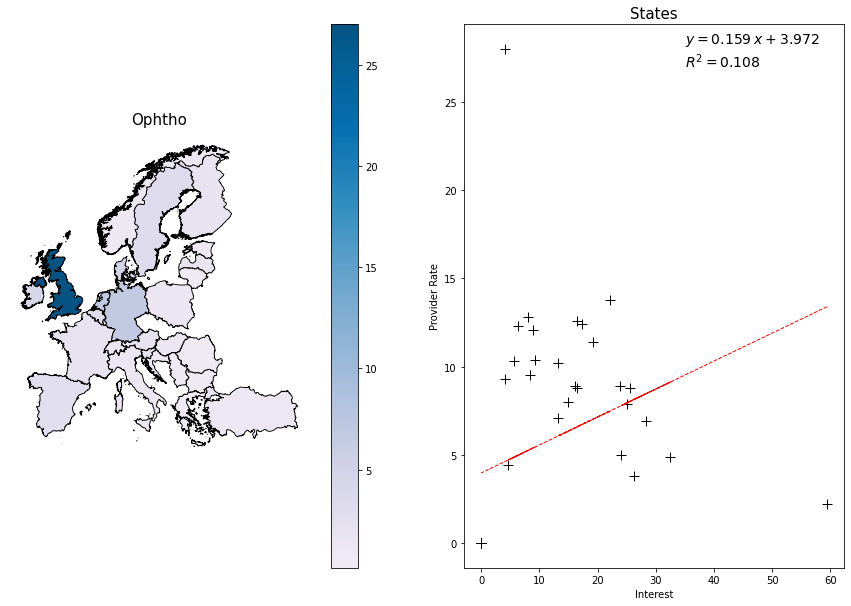

In [40]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title("Ophtho", fontdict={'fontsize': '15', 'fontweight' : '3'})
europe.plot(column="Need_21",
        cmap=new_cmap,
        linewidth=0.9,
        ax=ax1,
        edgecolor='0',
        legend=True)

ax3.set_title('States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Interest")
ax3.set_ylabel("Provider Rate")
x = europe["Interest_20"]
y = europe["Rate_100k"]

ax3.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(35, 27, text,
fontsize=14)

Text(20, 0, '$y=0.313\\;x+2.283$\n$R^2 = 0.399$')

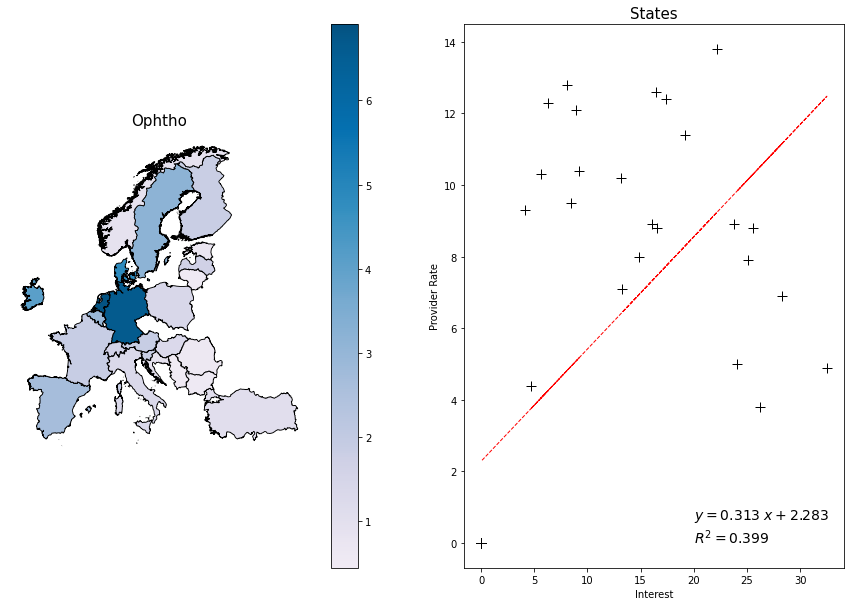

In [44]:
europe2 = europe[(europe.NAME != "United Kingdom") & (europe.NAME != "Greece")]
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title("Ophtho", fontdict={'fontsize': '15', 'fontweight' : '3'})
europe2.plot(column="Need_21",
        cmap=new_cmap,
        linewidth=0.9,
        ax=ax1,
        edgecolor='0',
        legend=True)

ax3.set_title('States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Interest")
ax3.set_ylabel("Provider Rate")
x = europe2["Interest_20"]
y = europe2["Rate_100k"]

ax3.plot(x,y,"+", 
ms=10, 
mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
"r--",
lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(20, 0, text,
fontsize=14)